# Продлит ли клиент подписку (Ахметов Данил Маратович)

## Описание набора данных

В задаче необходимо предсказать, продлит пользователь сервиса подписку или нет. Задача бинарной классификации.

** Список переменных **

1 - id	идентификатор.  
2 - taxactionSystem	 система налогообложения (категориальный).  
3 - regdt  Дата регистрации (число).  
4 - workerCount   количество сотрудников (число).  
5 - fssdccount   количество отправленных отчетов в ФСС из этой организации из БК за все время существования (число).  
6 - pfrdcCount   количество отправленных отчетов в ПФР из этой организации из БК за все время существования (число).  
7 - fnsdcCount   количество отправленных отчетов в ФНС из этой организации из БК за все время существования (число).  
8 - hasCloudCryptCertificate   был ли когда-либо в этой организации выпущен облачный сертификат (бинарный).  
9 - OrgCreationDate  дата добавления организации в БК Это не дата регистрации организации в ФНС и т.д., это дата, когда организация была добавлена (создана) в БК (число).  
10 - documentsCount  количество документов. Считает количество документов в системе (которые показываются на вкладке ""Все"") в этом количестве учитываются не все документы ) (число).  
11 - cnt_users   количество пользователей (число).  

Целевая переменная 12 - is_prolong  - продлится пользователь или нет. (бинарная: 1, 0)

Формат файла ответов:  
id, is_prolong  

**Импортируем бииблиотеки**

In [1]:
# -*- coding: utf-8 -*- 
import pandas as pd
import math
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler,LabelBinarizer
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.learning_curve import validation_curve,learning_curve

import xgboost as xgb
from evolutionary_search import EvolutionaryAlgorithmSearchCV

%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


**Загрузим данные**

In [2]:
train=pd.read_csv('../../data/prolongation_service_train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('../../data/prolongation_service_test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


**Выведем основные харакетристики переменных:**

In [3]:
print(train.shape)
train.describe(include = "all").T

(7626, 12)


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
id,7626,NaN,NaN,NaN,NaN,NaN,105076,2937.32,100001,102548,105056,107638,110167
taxactionSystem,7626,23,ОСНО,2752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regdt,7626,3030,2015-01-10,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workerCount,7626,NaN,NaN,NaN,NaN,NaN,0.900865,1.03024,0,0,1,1,6
fssdccount,7626,NaN,NaN,NaN,NaN,NaN,0.818778,0.82958,0,0,1,2,3
pfrdcCount,7626,NaN,NaN,NaN,NaN,NaN,0.833071,0.942024,0,0,1,2,4
fnsdcCount,7626,NaN,NaN,NaN,NaN,NaN,1.16444,1.03625,0,0,1,2,4
hasCloudCryptCertificate,7626,NaN,NaN,NaN,NaN,NaN,0.514293,0.499828,0,0,1,1,1
OrgCreationDate,7626,737,1900-01-01 00:00:00,1264,1900-01-01 00:00:00,2016-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
documentsCount,7626,NaN,NaN,NaN,NaN,NaN,4.07933,2.74458,0,1,5,6,10


**Визуализируем данные**

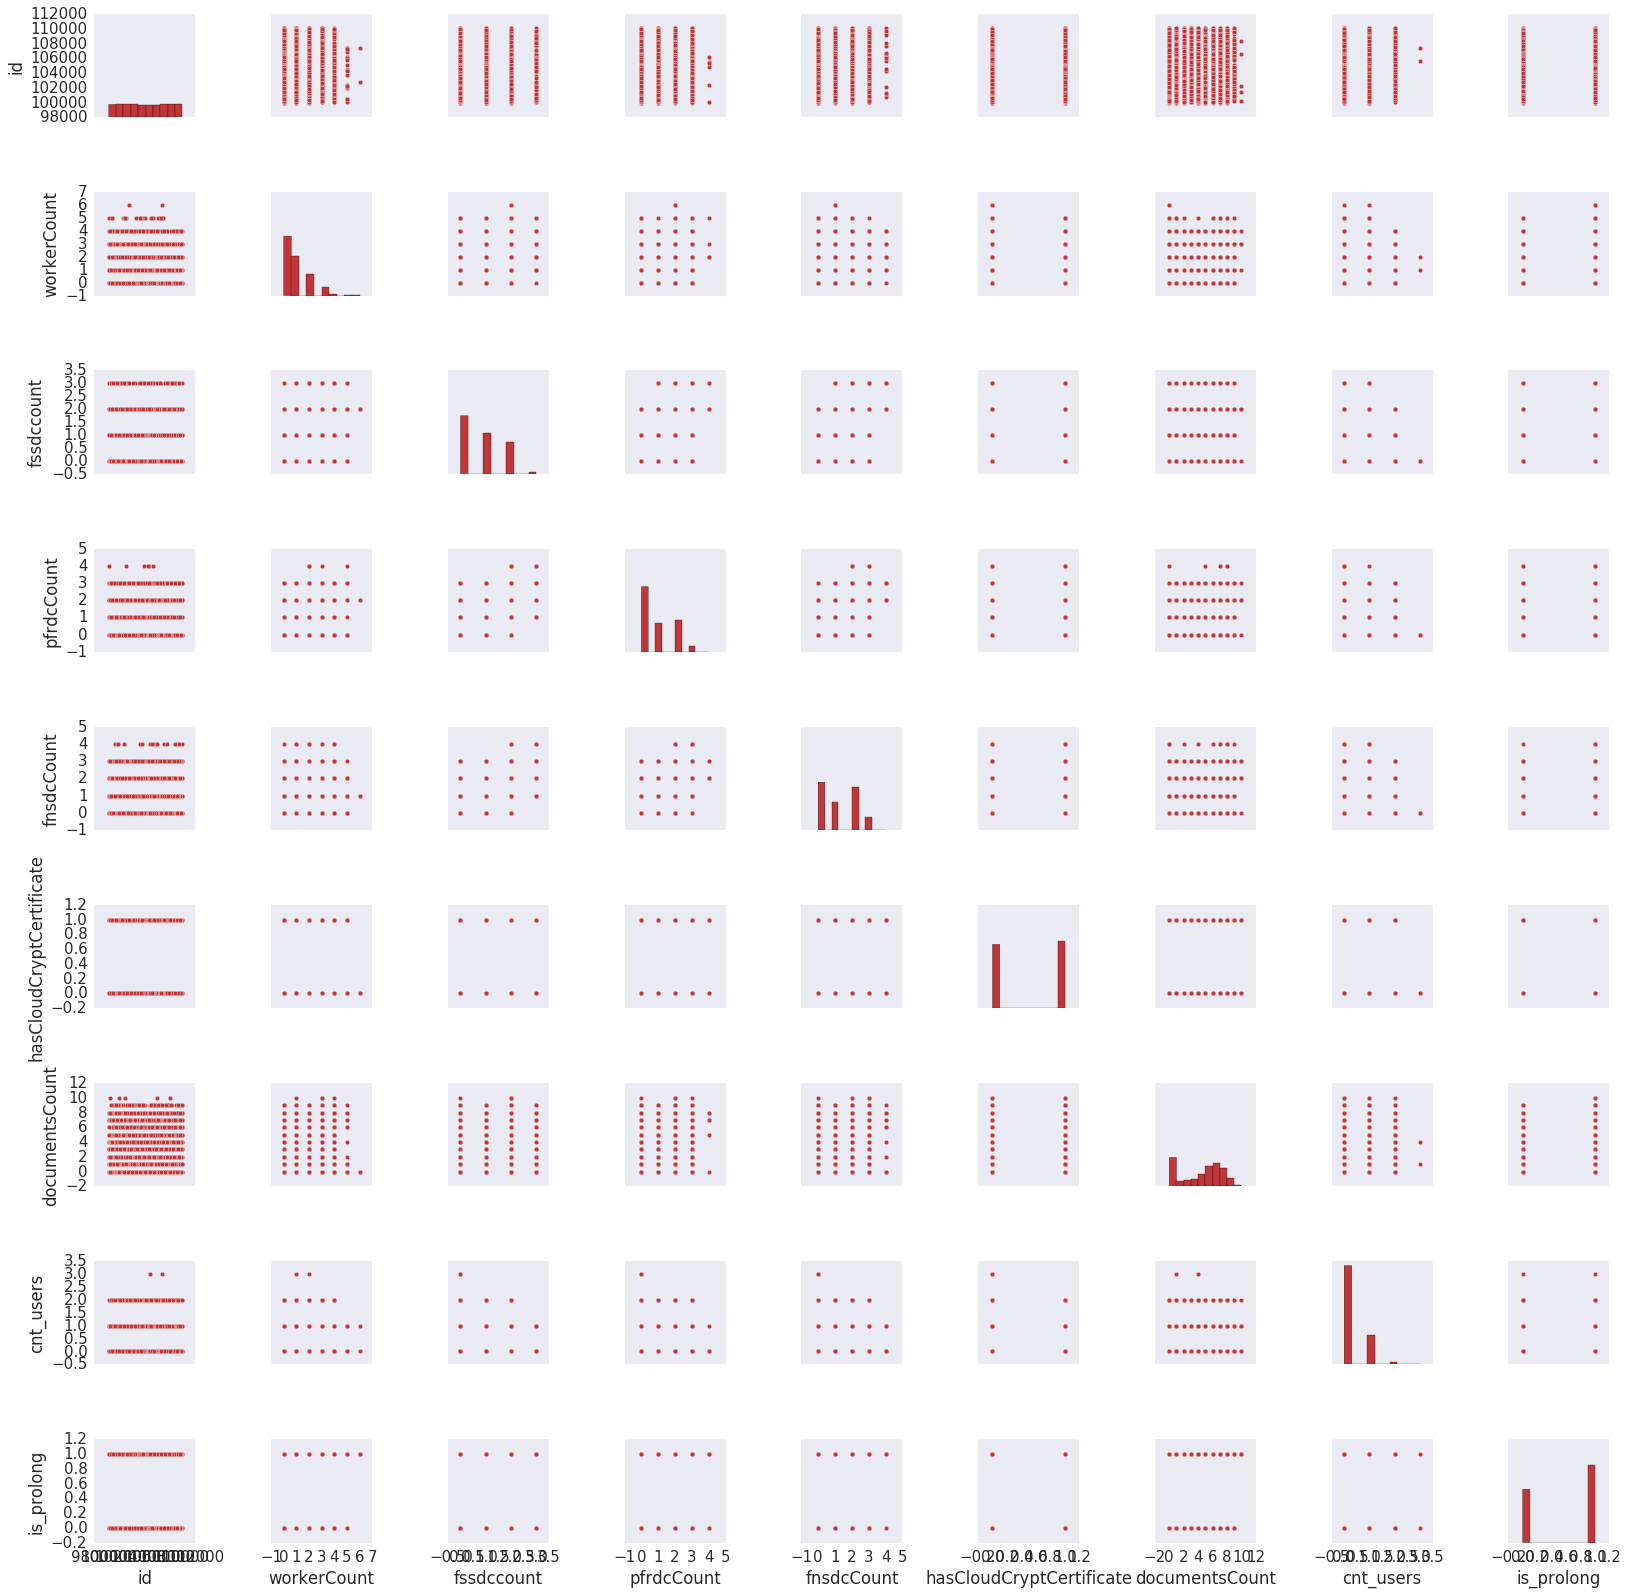

In [4]:
sns.pairplot(train)

### Распределение целевой переменной

Распределение целевой переменной: 	


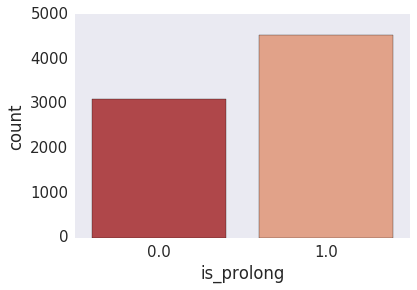

In [5]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

Имеется небольшой дисбаланс классов, избавимся от него дальше.

### Корреляция

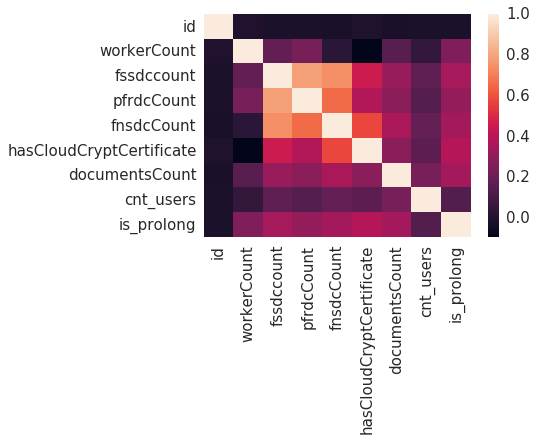

In [6]:
sns.heatmap(train.corr(method='pearson'),xticklabels=True,yticklabels=True);

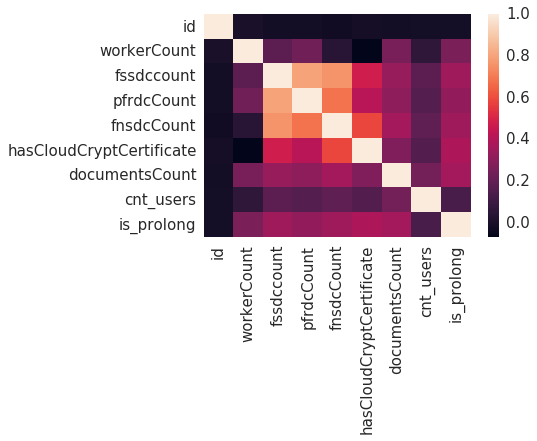

In [7]:
sns.heatmap(train.corr(method='spearman'),xticklabels=True,yticklabels=True);

Корреляция признаков "count" обусловлена тем, что чем чаще клиент пользуется сервисом и отправляет отчетность, тем больше он захочет продлить сервис. 

## Предобработка данных

In [8]:
df = pd.concat([train,test],ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10168 entries, 0 to 10167
Data columns (total 12 columns):
OrgCreationDate             10168 non-null datetime64[ns]
cnt_users                   10168 non-null float64
documentsCount              10168 non-null float64
fnsdcCount                  10168 non-null float64
fssdccount                  10168 non-null float64
hasCloudCryptCertificate    10168 non-null int64
id                          10168 non-null int64
is_prolong                  7626 non-null float64
pfrdcCount                  10168 non-null float64
regdt                       10168 non-null object
taxactionSystem             10168 non-null object
workerCount                 10168 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 953.3+ KB


In [9]:
#Удалим столбец id, так как он не несет никакой информации
df.drop(columns=['id'],axis=1,inplace=True)
df.fillna(value=0,inplace=True)

In [10]:
#Заменим строчки с кривой датой
#Дата 0001-01-01 обусловлена default value в sql server, т.е при вставке данных в таблицу не была указана дата 
df['regdt'] = df['regdt'].replace(['0001-01-01 00:00:00.0000000'],u'2013-07-16') # 2013-07-16 медиана
#приведем дату в нужный формат
df[['regdt','OrgCreationDate']]=df[['regdt','OrgCreationDate']].apply(pd.to_datetime)
df['regdt'] = df['regdt'].fillna(value=pd._libs.tslib.Timestamp('2013-07-16 00:00:00'))

In [11]:
#Приведем колонки к формату int
columns = df.select_dtypes(['floating']).columns
df[columns] = df[columns].astype('int64')

#Работаем с датой, достанем год, месяц, день
df['regdt_year']=pd.DatetimeIndex(df['regdt']).year
df['regdt_month']=pd.DatetimeIndex(df['regdt']).month
df['regdt_day']=pd.DatetimeIndex(df['regdt']).day

df['OrgCreationDate_year']=pd.DatetimeIndex(df['OrgCreationDate']).year.astype('int64')
df['OrgCreationDate_month']=pd.DatetimeIndex(df['OrgCreationDate']).month.astype('int64')
df['OrgCreationDate_day']=pd.DatetimeIndex(df['OrgCreationDate']).day.astype('int64')

df['delta_year']=df['regdt_year']-df['OrgCreationDate_year']

#Попробуем добавить кол-во лет с момента регистрации
df['today-regdt_year']=2018-df['regdt_year']
df['today-OrgCreationDate_year']=2018-df['OrgCreationDate_year']

df.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10168 entries, 0 to 10167
Data columns (total 18 columns):
cnt_users                     10168 non-null int64
documentsCount                10168 non-null int64
fnsdcCount                    10168 non-null int64
fssdccount                    10168 non-null int64
hasCloudCryptCertificate      10168 non-null int64
is_prolong                    10168 non-null int64
pfrdcCount                    10168 non-null int64
taxactionSystem               10168 non-null object
workerCount                   10168 non-null int64
regdt_year                    10168 non-null int64
regdt_month                   10168 non-null int64
regdt_day                     10168 non-null int64
OrgCreationDate_year          10168 non-null int64
OrgCreationDate_month         10168 non-null int64
OrgCreationDate_day           10168 non-null int64
delta_year                    10168 non-null int64
today-regdt_year              10168 non-null int64
today-OrgCreationDate_y

**Достанем из признака taxactionSystem систему налогооблажения и величину ставки**

In [12]:
new_tax=pd.DataFrame(columns=['tax','stavka'])
for idx,i in enumerate(df.taxactionSystem):
    temp=i.split(', ')
    if len(temp)!=2:
        new_tax.loc[idx]=[temp[0],0]
    else:
        new_tax.loc[idx]=[temp[0],int(str(re.search(r'\d+%', temp[1]).group(0))[:-1])]
        
df['tax']=new_tax['tax']
df['stavka']=new_tax['stavka']
df.drop(columns='taxactionSystem',axis=1,inplace=True)

#train.dropna(axis=0, how='any',inplace=True)
df['stavka'] = df['stavka'].astype('int64')
df.head()

,cnt_users,documentsCount,fnsdcCount,fssdccount,hasCloudCryptCertificate,is_prolong,pfrdcCount,workerCount,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day,delta_year,today-regdt_year,today-OrgCreationDate_year,tax,stavka
0,0,2,0,0,0,1,0,5,1994,3,26,2014,4,12,-20,24,4,УСН,6
1,0,5,0,0,0,0,0,1,2012,12,5,2014,9,22,-2,6,4,ОСНО,0
2,0,0,2,3,0,1,3,1,2009,11,15,2016,5,4,-7,9,2,УСН,6
3,0,0,0,0,0,0,0,1,2015,8,9,2015,9,24,0,3,3,УСН,15
4,0,4,0,0,0,0,0,0,2015,3,29,2015,3,4,0,3,3,УСН,15


### Закодируем категориальные признаки с помощью One hot encoding

[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


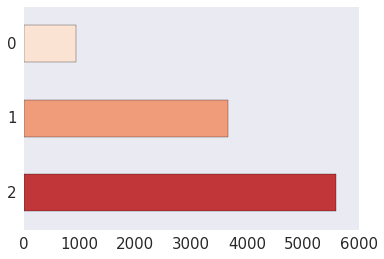

In [13]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(np.hstack((df['tax']))))
mapped_education.value_counts().plot.barh()

# integer encode
integer_encoded = label_encoder.fit_transform(df['tax']).astype('int')

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded[:5])

# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])

df=df.join(pd.DataFrame(onehot_encoded,columns=["tax"+str(i) for i in range(onehot_encoded.shape[1])]),how='outer')
df.drop(columns='tax',axis=1,inplace=True)
#train.dropna(axis=0, how='any',inplace=True)
df[df.columns] = df[df.columns].astype('int64')

In [14]:
df.head()

,cnt_users,documentsCount,fnsdcCount,fssdccount,hasCloudCryptCertificate,is_prolong,pfrdcCount,workerCount,regdt_year,regdt_month,...,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day,delta_year,today-regdt_year,today-OrgCreationDate_year,stavka,tax0,tax1,tax2
0,0,2,0,0,0,1,0,5,1994,3,...,2014,4,12,-20,24,4,6,0,0,1
1,0,5,0,0,0,0,0,1,2012,12,...,2014,9,22,-2,6,4,0,0,1,0
2,0,0,2,3,0,1,3,1,2009,11,...,2016,5,4,-7,9,2,6,0,0,1
3,0,0,0,0,0,0,0,1,2015,8,...,2015,9,24,0,3,3,15,0,0,1
4,0,4,0,0,0,0,0,0,2015,3,...,2015,3,4,0,3,3,15,0,0,1


In [15]:
print len(train), len(test)

7626 2542


In [16]:
train = df[:][:len(train)]
test = df[:][len(train):]

**Разделим выборку на обучающую и тестовую**

In [17]:
target=train.is_prolong
train.drop(axis=1,columns=['is_prolong'],inplace=True)
train_X,test_X,train_y,test_y=train_test_split(train,target,shuffle=True,random_state=17,test_size=0.2)

**Выровняем классы с помощью SMOTE**

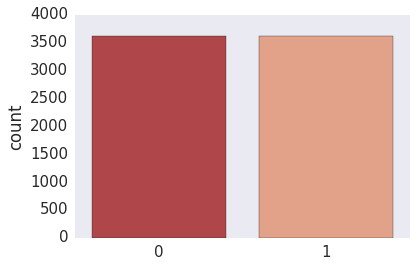

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind='borderline1', random_state=17)
train_X, train_y = smote.fit_sample(train_X, train_y)
train_X=pd.DataFrame(train_X,columns=train.columns)

sns.countplot(train_y)

# Обучение моделей
## Логистическая регрессия

В качестве метрики будем использовать ROC_AUC, так как имеем дело с несбалансированной выборкой, и порог, равный 0.5, может оказывается не оптимальным 

Напишем функцию для получения метрики roc-auc

In [19]:
def getROC_AUC(method,test_X,test_y):
    precision, recall, thresholds = precision_recall_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.title("precision-recall")
    plt.plot(recall,precision)

    fpr, tpr, thresholds = roc_curve(test_y, method.predict_proba(test_X)[:,1])
    plt.figure()
    plt.title("ROC-AUC")
    plt.plot(fpr,tpr)

Попробуем применить LR с подбором параметров с помощью EvolutionaryAlgorithmSearchCV

In [20]:
lr=LogisticRegression(n_jobs=-1)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

paramgrid = {"lr__C": np.logspace(-8, 1, 10),
             "lr__penalty"     : ['l1','l2']}

np.random.seed(17)

cv = EvolutionaryAlgorithmSearchCV(estimator=lr_pipe,
                                   params=paramgrid,
                                   scoring="roc_auc",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=4)
cv.fit(train_X, train_y)

Types [1, 2] and maxint [1, 9] detected
--- Evolve in 20 possible combinations ---
gen	nevals	avg     	min	max     	std     
0  	10    	0.709488	0.5	0.812064	0.137546
1  	2     	0.800301	0.784019	0.812064	0.0127445
2  	9     	0.80845 	0.788263	0.812061	0.00726193
3  	6     	0.812034	0.811888	0.812061	4.90509e-05
4  	3     	0.812052	0.812046	0.812061	6.17906e-06
5  	6     	0.809678	0.788263	0.812061	0.00713834 
6  	7     	0.809682	0.788263	0.812064	0.00713972 
7  	4     	0.812062	0.81206 	0.812063	1.03133e-06
8  	7     	0.812063	0.81206 	0.812064	1.42572e-06
9  	5     	0.812063	0.812059	0.812064	1.93809e-06
10 	4     	0.812064	0.812061	0.812065	1.11277e-06
Best individual is: {'lr__penalty': 'l1', 'lr__C': 1.0}
with fitness: 0.812064101321


Построим модель с лучшими параметрами, и посмотрим качество на отложенной выборке

In [21]:
lr = LogisticRegression(n_jobs=-1,penalty='l1',C=1)
scaler_lr=StandardScaler()

train_X_scale=scaler_lr.fit_transform(train_X)
test_X_scale=scaler_lr.transform(test_X)

lr.fit(train_X_scale, train_y)
lr_pred=lr.predict(test_X_scale)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr.predict_proba(test_X_scale)[:,-1])

0.752948885976
0.833722886391


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


**Оценим важность признаков**

Лассо обнуляет веса ненужных признаков

In [22]:
features = pd.DataFrame(lr.coef_.reshape((20,1)),
                        index=train_X.columns, 
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features

,Importance
hasCloudCryptCertificate,0.727652
workerCount,0.639185
documentsCount,0.444237
fssdccount,0.328416
fnsdcCount,0.175883
today-regdt_year,0.163274
OrgCreationDate_year,0.098300
cnt_users,0.039488
regdt_month,0.032157
OrgCreationDate_month,0.020710


Видим, что наибольший вклад внёс признак hasCloudCryptCertificate. Компании, у которых имеется электронаая подпись, чаще продливают подписку, это подтверждено практикой.

## Случайный лес

Сделаем тоже самое для Случайного леса

In [23]:
rnd_forest=RandomForestClassifier(n_jobs=-1,random_state=17,oob_score=False)

forest_params = {'max_depth': [5,6,7,8,9,10]
                ,'max_features': [1,2,3,4,5,6,7]
                ,'min_samples_leaf':[1,2,3,5,7,8]
                ,'n_estimators':[70,80,90,100,110,125,135,150]
                }

np.random.seed(17)

cv = EvolutionaryAlgorithmSearchCV(estimator=rnd_forest,
                                   params=forest_params,
                                   scoring="roc_auc",
                                   cv=5,
                                   verbose=1,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(train_X, train_y)

Types [1, 1, 1, 1] and maxint [6, 7, 5, 5] detected


/usr/local/lib/python2.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


--- Evolve in 2016 possible combinations ---
gen	nevals	avg     	min     	max     	std       
0  	100   	0.886286	0.864007	0.899125	0.00893427
1  	71    	0.893199	0.879557	0.899182	0.00483256
2  	56    	0.896781	0.888586	0.899475	0.00226254
3  	62    	0.898175	0.878138	0.899863	0.00224029
4  	64    	0.898758	0.888361	0.900099	0.0013426 
5  	59    	0.899056	0.887282	0.900099	0.00134805
6  	57    	0.899284	0.890551	0.900099	0.00115246
7  	76    	0.899512	0.881904	0.900099	0.00181037
8  	59    	0.899724	0.889948	0.900099	0.00117845
9  	56    	0.899399	0.881904	0.900099	0.00298003
10 	53    	0.899947	0.891236	0.900099	0.000947094
Best individual is: {'max_features': 5, 'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 1}
with fitness: 0.900098712717


**Построим лучшую модель**

In [24]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=150,max_depth=10,max_features=5,min_samples_leaf=1,random_state=17)
rnd_forest.fit(train_X,train_y)
pred_forest=rnd_forest.predict(test_X)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, rnd_forest.predict_proba(test_X)[:,-1])

0.810615989515
0.876544491374


### Наиболее важные признаки

In [25]:
features = pd.DataFrame(rnd_forest.feature_importances_,
                        index=train_X.columns, 
                        columns=['Importance']).sort_values(['Importance'], ascending=False)
features

,Importance
hasCloudCryptCertificate,0.187376
documentsCount,0.130072
fnsdcCount,0.111624
fssdccount,0.090978
workerCount,0.076570
pfrdcCount,0.047089
today-OrgCreationDate_year,0.045983
OrgCreationDate_year,0.042403
delta_year,0.038918
regdt_day,0.034999


Случайный лес, также в качестве наиболее важного признака выбрал hasCloudCryptCertificate

**График "важности" признаков**

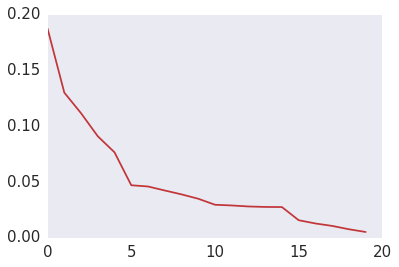

In [26]:
plt.plot(range(len(features.Importance.tolist())), 
         features.Importance.tolist())

## График кривой обучения

In [29]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

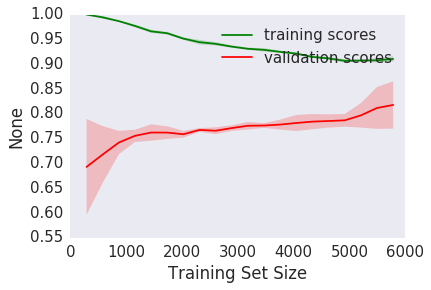

In [43]:
plot_learning_curve(RandomForestClassifier(n_jobs=-1,n_estimators=150,
                                           max_depth=10,max_features=5,
                                           min_samples_leaf=1,random_state=17),
                   train_X, train_y, scoring=None, cv=5)

**Построим валидационную кривую для данных параметров леса. В качестве параметра сложности будем использовать max_depth:**

In [44]:
def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name,
                                           cv_param_values, cv=5,
                                                  scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

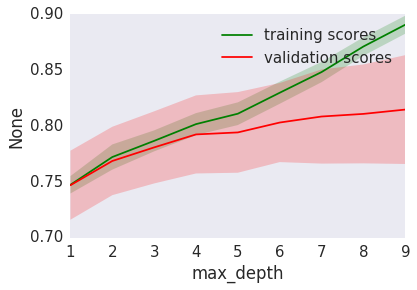

In [46]:
max_depth = range(1,10)
plot_validation_curve(RandomForestClassifier(n_jobs=-1,n_estimators=150,
                                           max_depth=10,max_features=5,
                                           min_samples_leaf=1,random_state=17), train_X, train_y, 
                      cv_param_name='max_depth', 
                      cv_param_values=max_depth,
                      scoring=None)

Найдём лучшие параметры для ещё нескольких алгоритмов и попробуем EnsembleClassifier

## Градиентрный бустинг

Попробуем градиентный бустинг над деревьями

In [48]:
g_boost=GradientBoostingClassifier(random_state=17,learning_rate=0.6)
boost_params = {'max_depth': range(1,10)
                ,'max_features': range(1,13)
                ,'min_samples_leaf':range(1,5)
                ,'n_estimators':range(10,150,10)
                ,'learning_rate':np.arange(0.01,1,0.05)
                }
np.random.seed(17)
cv = EvolutionaryAlgorithmSearchCV(estimator=g_boost,
                                   params=boost_params,
                                   scoring="roc_auc",
                                   cv=5,
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=10,
                                   n_jobs=8)
cv.fit(X_train, train_y)

Types [1, 1, 2, 1, 1] and maxint [11, 13, 19, 8, 3] detected
--- Evolve in 120960 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	50    	0.881221	0.838893	0.898159	0.0116225
1  	32    	0.88785 	0.867192	0.899699	0.00801659
2  	25    	0.893555	0.868378	0.899084	0.00587248
3  	34    	0.896669	0.884537	0.899139	0.00278542
4  	31    	0.897117	0.879783	0.899139	0.00398792
5  	31    	0.898148	0.889342	0.899521	0.00205927
6  	30    	0.898885	0.889034	0.899521	0.001425  
7  	35    	0.898493	0.883286	0.900106	0.00297835
8  	39    	0.899172	0.890126	0.900106	0.00135516
9  	32    	0.899207	0.891931	0.900106	0.00134477
10 	32    	0.898709	0.887766	0.900195	0.00275968
Best individual is: {'max_features': 5, 'n_estimators': 120, 'learning_rate': 0.16000000000000003, 'max_depth': 4, 'min_samples_leaf': 4}
with fitness: 0.900194555879


**Построим лучшую модель**

In [49]:
g_boost=GradientBoostingClassifier(random_state=17,n_estimators=120,max_depth=4,learning_rate=0.16,max_features=5,min_samples_leaf=4)
g_boost.fit(train_X,train_y)
pred_boost=g_boost.predict(test_X)
print accuracy_score(test_y,pred_boost)
print roc_auc_score(test_y, g_boost.predict_proba(test_X)[:,-1])

0.802752293578
0.866837282554


## xgboost

In [35]:
# x_boost=xgb.XGBClassifier()
# X_boost_params = {'max_depth': range(1,10)
#                 ,'n_estimators':range(10,150,10)
#                 ,'learning_rate':np.arange(0.01,0.2,0.05)
#                 }

# np.random.seed(17)
# cv = EvolutionaryAlgorithmSearchCV(estimator=x_boost,
#                                    params=X_boost_params,
#                                    scoring="accuracy",
#                                    cv=5,
#                                    verbose=1,
#                                    population_size=50,
#                                    gene_mutation_prob=0.10,
#                                    gene_crossover_prob=0.5,
#                                    tournament_size=3,
#                                    generations_number=10,
#                                    n_jobs=8)
# cv.fit(X_train, train_y)

**Построим лучшую модель**

In [36]:
# x_boost=xgb.XGBClassifier(n_estimators=70,learning_rate=0.06,max_depth=4)
# x_boost.fit(X_train,train_y)
# pred_x_boost=x_boost.predict(X_test)
# print accuracy_score(test_y,pred_x_boost)
# print roc_auc_score(test_y, x_boost.predict_proba(X_test)[:,-1])

## Метод ближайших соседей

In [50]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance',n_neighbors=14))])
n_neighbors=range(2, 15)
knn_params = {'knn__n_neighbors': n_neighbors}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
knn_grid.fit(train_X, train_y)
print (knn_grid.best_params_, knn_grid.best_score_)
print accuracy_score(test_y, knn_grid.predict(test_X))
print roc_auc_score(test_y, knn_grid.predict_proba(test_X)[:,-1])

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   10.4s finished


({'knn__n_neighbors': 4}, 0.80013831258644541)
0.747706422018
0.812952788317


## EnsembleClassifier

In [51]:
from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner
from sklearn import clone

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


sclf 0.866985825757
eclf 0.873401818312


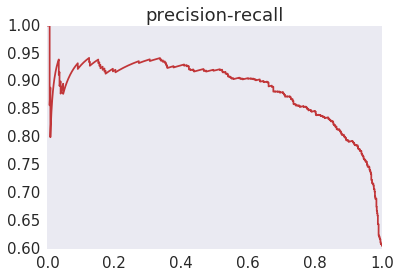

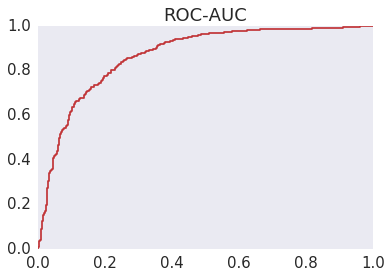

In [52]:
# Initializing Classifiers
clf1 = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance',n_neighbors=14))])
clf2 = RandomForestClassifier(n_jobs=-1,n_estimators=150,max_depth=10,max_features=5,min_samples_leaf=1,random_state=17)
clf3 = GradientBoostingClassifier(random_state=17,n_estimators=110,max_depth=7,learning_rate=0.11,max_features=3,min_samples_leaf=3)
clf4 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1,penalty='l2',C=10,random_state=17))])
clf5 = RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=10,random_state=17)

# Creating Ensemble
ensemble = Ensemble([clf1, clf2, clf3, clf4, clf5])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# Creating Stacking
layer_1 = Ensemble([clf1, clf2, clf3, clf4])
layer_2 = Ensemble([clone(clf5)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)


# Loading some example data
X = X_train
y = train_y

d = {yi : i for i, yi in enumerate(set(y))}
y = np.array([d[yi] for yi in y])

sclf.fit(X,y)
print 'sclf ' + str(roc_auc_score(test_y,sclf.predict_proba(X_test)[:,-1]))
eclf.fit(X,y)
print 'eclf ' + str(roc_auc_score(test_y,eclf.predict_proba(X_test)[:,-1]))
getROC_AUC(sclf,X_test,test_y)

Результаты ну прям не очень, попробуем что-нибудь по-серьезнее:)

## Разделим обучающую выборку пополам, на первой половине обучим классификаторы, на второй ...

In [53]:
train_X,val_X,train_y,val_y=train_test_split(train,target,shuffle=True,random_state=17,test_size=0.2)
train_X1,train_X2,train_y1,train_y2=train_test_split(train_X,train_y,random_state=17,test_size=0.7)

In [54]:
data = pd.DataFrame()
    
lr=LogisticRegression(random_state=17)
lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1,penalty='l2',C=10,random_state=17))])
lr.fit(train_X1,train_y1)
data['lr'] = lr.predict_proba(train_X2)[:,-1]
    
random_forest = RandomForestClassifier(n_jobs=-1,n_estimators=70,max_depth=10,max_features=4,min_samples_leaf=3,random_state=17)
random_forest.fit(train_X1,train_y1)
data['random_forest'] = random_forest.predict_proba(train_X2)[:,-1]
    
gradient_boosting = GradientBoostingClassifier(random_state=17,n_estimators=140,max_depth=5,learning_rate=0.06,max_features=6,min_samples_leaf=4)
gradient_boosting.fit(train_X1,train_y1)
data['gradient_boosting'] = gradient_boosting.predict_proba(train_X2)[:,-1]
    
x_boost=xgb.XGBClassifier(n_estimators=70,learning_rate=0.06,max_depth=4)
x_boost.fit(train_X1,train_y1)
data['x_boost']=x_boost.predict_proba(train_X2)[:,-1]
    
kneighbors = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1,weights='distance',n_neighbors=14))])
kneighbors.fit(train_X1,train_y1)
data['kneighbors']=kneighbors.predict_proba(train_X2)[:,-1]

In [55]:
data.head()

,lr,random_forest,gradient_boosting,x_boost,kneighbors
0,0.120927,0.249588,0.090224,0.111918,0.130111
1,0.945901,0.937890,0.943864,0.934498,0.935232
2,0.955197,0.894764,0.909740,0.909649,0.793587
3,0.082062,0.095304,0.087541,0.094575,0.066121
4,0.836299,0.915256,0.964758,0.911433,0.788913


Функция, возвращающая предсказанные данные:

In [56]:
def get_predictions(models,train_X2):
    data = pd.DataFrame()
    for idx, i in enumerate(models):
        data[str(idx)] = i.predict_proba(train_X2)[:,-1]
    return data

In [57]:
train_X2 = get_predictions([lr,random_forest,gradient_boosting,x_boost,kneighbors], train_X2)
val_X = get_predictions([lr,random_forest,gradient_boosting,x_boost,kneighbors], val_X)

Обучим простую логистическую регрессию:

In [58]:
lr2 = LogisticRegression(C=0.5)
lr2.fit(train_X2,train_y2)
print accuracy_score(val_y,lr2.predict(val_X))
print roc_auc_score(val_y,lr2.predict_proba(val_X)[:,-1])

0.80996068152
0.865747369175


Результат тоже не впечатляет.

# Test prediction

Наибольшее значение ROC_AUC у случайного леса, поэтому применим его для формирования итогового прогноза.

In [59]:
rnd_forest=RandomForestClassifier(n_jobs=-1,n_estimators=150,max_depth=10,max_features=5,min_samples_leaf=1,random_state=17)
rnd_forest.fit(train,target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [60]:
test.drop(axis=1,columns='is_prolong', inplace=True)

In [63]:
pd.DataFrame(np.stack((range(len(test)),rnd_forest.predict(test)), axis=1),columns=['id','is_prolong']).to_csv('submission.csv', index=False)

In [64]:
pd.read_csv('submission.csv').head()

,id,is_prolong
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1


К сожалению, оценить наш прогноз не получится, так как мне ещё не предоставили ответы. Будем надеяться, что оценка на тестовой выборке, будет близка к оценке на кросс валидации.